## Tweet project Part 4

#### 1. Duplicate and similar tweets on sample dataset
#### 2. Repeating the analysis within each organisation




In [5]:
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [2]:
pip install nltk -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 65.3 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.4
    Uninstalling nltk-3.6.4:
      Successfully uninstalled nltk-3.6.4
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import time
import subprocess

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import udf

In [7]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [8]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [10]:
## Read processed data
bucket_name = 'prayutjain-tweet-bucket'
prefix = 'processed_data'

df = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')

22/12/07 23:40:36 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
## Read organisation data
bucket_name = 'prayutjain-tweet-bucket'
prefix = 'influencers'

df_org = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')

In [9]:
df_org.printSchema()

root
 |-- user_id_str: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- user_location: string (nullable = true)
 |-- if_retweet: boolean (nullable = true)
 |-- total_count: long (nullable = true)
 |-- avg_retweet: double (nullable = true)
 |-- total_retweet: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- popularity_score: double (nullable = true)
 |-- relevance_score: double (nullable = true)
 |-- Organisation: string (nullable = true)



### 0.1 Join the 2 datasets


In [12]:
df_org1 = df_org\
.select('user_id_str','Organisation')\
.dropDuplicates(['user_id_str'])

df1 = df\
.join(df_org1, 'user_id_str', 'left')

df1 = df1.na.fill(value='Other',subset=['Organisation'])

In [30]:
df1.printSchema()

root
 |-- user_id_str: string (nullable = true)
 |-- user_created_at: timestamp (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_favourites_count: long (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_friends_count: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_protected: boolean (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_statuses_count: long (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- user_withheld_in_countries: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_location: string (nullable = true)
 |-- tweet_coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- tweet_created_at: timestamp (nullable = true)
 |-- tweet_id_str: string (nullable = true)
 |-- tweet_lang: string (nullable = tru

# Part 1 - taking a random sample

### Step 1.  Clean the data, remove stopwords and create index

In [16]:
df1_smpl = df1.sample(withReplacement=True, fraction=0.001, seed=3)

df2 = df1_smpl.orderBy('tweet_created_at',ascending=False).select('user_id_str','Organisation',col('tweet_text').alias('text'))\
.filter(df1_smpl['tweet_retweeted_status'].isNull())

df3 = df2.select('text').rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = df3\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()


In [17]:
row = Row('text')
df_text = df3.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{@kimmieg56 @Trut...,2977
{Power given by p...,2978
{I'll be real wit...,2979
{Tues Sep 23 Wein...,2980
"{Once, Sae ever b...",2981


In [18]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[schools, canceled, bc, astros, world, come, university, pleaaaaase]",0
1,"[hearing, stories, schools, refusing, offers, room]",1
2,"[unless, kid, grad, school, taking, specialized, courses]",2
3,"[went, school, special]",3
4,"[got, mine, assignment, memorize, chapters, old]",4


In [19]:
df_tokens.count()

12345

### Step 2. Fit countvectorizer to create word features

In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [21]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[schools, canceled, bc, astros, world, come, university, pleaaaaase]",0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[hearing, stories, schools, refusing, offers, room]",1,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[unless, kid, grad, school, taking, specialized, courses]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[went, school, special]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[got, mine, assignment, memorize, chapters, old]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [96]:
df_vectorize.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- features: vector (nullable = true)



### Step 3. Fit MinHashLSH to create hash table

**Note:** Adding more hash tables will increase the accuracy at the expense of training time

In [22]:
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()
df_vectorize = df_vectorize.where(num_nonzeros("features") >= 1)

mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [23]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
1677,{- Pro: Popular o...,"[popular, online,...","(15486,[42,50,160...","[[8.20487982E8], ..."
1697,{@RivalsWardlaw R...,"[rattler, hope, s...","(15486,[1,106,190...","[[6.510351E7], [1..."
1224,{“A socially awkw...,"[socially, awkwar...","(15486,[0,1,486,5...","[[4.7945584E7], [..."
1258,"{When MBBS, compu...","[computer, engine...","(15486,[26,343,44...","[[3.49697322E8], ..."
1277,{Hendon Hooker wa...,"[hendon, hooker, ...","(15486,[1,593,862...","[[5.4522156E7], [..."


In [76]:
#df_hashed_text.limit(10).withColumn('si',size('hashes')).show()

### Step 4. Establish similarity threshold and return near-duplicate records
**Note:** we are joining dataframe to itself to get near-duplicate pairs

#### Low jaccard distance

In [24]:
#df_hashed_text = df_hashed_text.filter(size(df_hashed_text["hashes"]) >= 1)

jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [25]:
df_dups_30 = df_dups_text
#df_dups_text.cache()
df_dups_text.orderBy('id_A').limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,3,1722,"(I went to school for special education. \n\n https://t.co/1TsytAITQJ,)","(I went to school for special education. https://t.co/dSLWhsu8aK,)"
1,0.000000,3,1102,"(I went to school for special education. \n\n https://t.co/1TsytAITQJ,)","(I went to school for special education. \n\n https://t.co/KdXlP3UICZ,)"
2,0.000000,3,1973,"(I went to school for special education. \n\n https://t.co/1TsytAITQJ,)","(I went to school for special education. https://t.co/CnNIHkWKHH,)"
3,0.000000,20,3945,"(@luiz1227_ A Crypto-Forex exchange (#BlueBit), NFT marketplace, Daily draws, charity schools and hundreds innovatio… https://t.co/OQ725XhZTO,)","(@facugambande A Crypto-Forex exchange (#BlueBit), NFT marketplace, Daily draws, charity schools and hundreds innova… https://t.co/l3DOKyWJ6Z,)"
4,0.166667,115,3006,"(🏈🇺🇸 Today's High School Football - Live Stream ⬇️\nEnfield vs Windsor\nSheehan vs Law\nCheshire vs Shelton\nEast Hartf… https://t.co/h1purLNvGJ,)","(🔴 LIVE !! High School Football Today's 2022\n\nParkville vs Urbana\nCurtis vs St. Mary's Ryken\nDuVal vs Suitland\n\nClic… https://t.co/VGqScQohbN,)"


In [26]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  12438
Duplicate titles based on { 0.3 } jaccard distance:  268
Unique titles based on { 0.3 } jaccard distance:  0.3 :  12170


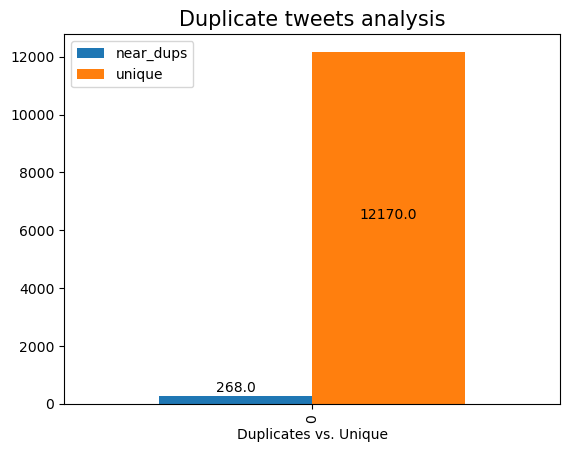

In [27]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicate tweets analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
df_dups_1 = df_dups_text.select(col('id_A').alias('id')).distinct().withColumn('is_dups',lit('near_dups'))

df_final = df2.select('Organisation').rdd.zipWithIndex().toDF(['org','id'])\
.join(df_dups_1,'id','left')\
.na.fill(value='unique',subset=['is_dups'])\
.select('id',col('org.Organisation').alias('org'),'is_dups')

df_final.show(10)

+---+-----+---------+
| id|  org|  is_dups|
+---+-----+---------+
| 26|Other|   unique|
| 29|Other|   unique|
|474|Other|   unique|
| 65|Other|   unique|
|191|Other|   unique|
|418|Other|   unique|
|541|Other|near_dups|
|558|Other|   unique|
|222|Other|   unique|
|270|Other|   unique|
+---+-----+---------+
only showing top 10 rows



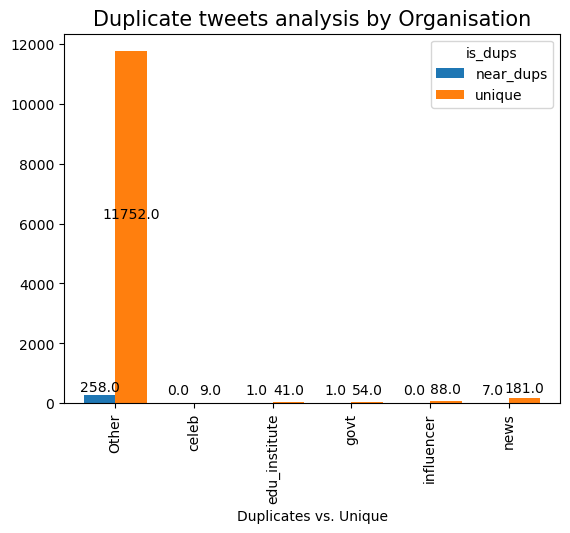

In [29]:
df_plt = df_final.groupBy('org','is_dups').agg(count('*').alias('cnt')).toPandas()

ax=df_plt.pivot(index='org', columns='is_dups', values='cnt').plot(kind='bar', fontsize=10, color=['C0', 'C1'],
                                                                align='center', width=0.8, 
                                                                xlabel="Duplicates vs. Unique")

ax.set_title('Duplicate tweets analysis by Organisation', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

# Part 2 - Doing the analysis within each organisation

In [13]:
def get_token_df(df, StopWords):
    tokens = df\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if x.isalnum()] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()
    
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    
    return df_tokens

def get_df_text(text, col):    
    row = Row(col)
    df_text = text.map(row).zipWithIndex().toDF([col, 'id'])
    return df_text

def get_vector_df(df_tokens):
    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)
    
    return df_vectorize

def get_hashed_df(df_vectorize, mh):
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
    return model, df_hashed

def getJaccardSim(df, jaccard_distance, model):

    df_dups_text = model.approxSimilarityJoin(
                        df, df, jaccard_distance
                    ).filter("datasetA.id < datasetB.id").select(
                        col("distCol"),
                        col("datasetA.id").alias("id_A"),
                        col("datasetB.id").alias("id_B"),
                        col("datasetA.text").alias('text_A'),
                        col("datasetB.text").alias('text_B')
                    )

    df_dups_text.cache()
    
    records = df.count()
    dups = df_dups_text.select('id_A').distinct().count()
    
    return records, dups

def sim_analysis(df, smpl_frac, org):
    df1_smpl = df.filter(df['Organisation'] == org).sample(withReplacement=True, fraction=smpl_frac, seed=123)
    
    df2 = df1_smpl.orderBy('tweet_created_at',ascending=False).select('user_id_str','Organisation',col('tweet_text').alias('text'))\
    .filter(df1_smpl['tweet_retweeted_status'].isNull())
    
    df3 = df2.select('text').rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
    
    ## Step 1 Clean data and create tokens
    StopWords = stopwords.words("english")
    
    df_tokens = get_token_df(df3, StopWords)
    
    df_text = get_df_text(df3, 'text')
    
    ## Step 2 Fit count vectorize to create features
    df_vectorize = get_vector_df(df_tokens)
    
    @udf("long")
    def num_nonzeros(v):
        return v.numNonzeros()
    df_vectorize = df_vectorize.where(num_nonzeros("features") >= 1)
    
    ## Step 3 Create hashed df
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model, df_hashed = get_hashed_df(df_vectorize, mh)
    
    df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
    
    ## Step 4 Find the similar words by applying minHashLSH
    df_dups_text = []
    records, dups = getJaccardSim(df_hashed_text, 0.2,model)
    df_dups_text.append([org, records, dups, records - dups, 0.2])

    records, dups = getJaccardSim(df_hashed_text, 0.4,model)
    df_dups_text.append([org, records, dups, records - dups, 0.4])

    records, dups = getJaccardSim(df_hashed_text, 0.6,model)
    df_dups_text.append([org, records, dups, records - dups, 0.6])

    records, dups = getJaccardSim(df_hashed_text, 0.8,model)
    df_dups_text.append([org, records, dups, records - dups, 0.8])
    
    return df_dups_text

In [32]:
df1.groupBy('Organisation').agg(count('*').alias('cnt_tweets')).show()

+-------------+----------+
| Organisation|cnt_tweets|
+-------------+----------+
|edu_institute|     80579|
|         news|    232388|
|        Other|  34628191|
|    nonprofit|         3|
|        celeb|     18660|
|   influencer|    134553|
|         govt|     92387|
+-------------+----------+



In [39]:
df1.select('Organisation').distinct().show()

+-------------+
| Organisation|
+-------------+
|edu_institute|
|         news|
|        Other|
|    nonprofit|
|        celeb|
|   influencer|
|         govt|
+-------------+



In [26]:
dups_infl = sim_analysis(df1, 0.1, 'edu_institute')
dups_news = sim_analysis(df1, 0.07, 'news')
dups_other = sim_analysis(df1, 0.0005, 'Other')
#dups_np = sim_analysis(df1, 1, 'nonprofit')
dups_celeb = sim_analysis(df1, 0.9, 'celeb')
dups_inf = sim_analysis(df1, 0.1, 'influencer')
dups_govt = sim_analysis(df1, 0.1, 'govt')


In [43]:
dups_infl1 = pd.DataFrame(dups_infl, columns = ['org','counts', 'dups', 'unique', 'threshold'])
dups_news1 = pd.DataFrame(dups_news, columns = ['org','counts', 'dups', 'unique', 'threshold'])
dups_other1 = pd.DataFrame(dups_other, columns = ['org','counts', 'dups', 'unique', 'threshold'])
dups_celeb1 = pd.DataFrame(dups_celeb, columns = ['org','counts', 'dups', 'unique', 'threshold'])
dups_inf1 = pd.DataFrame(dups_inf, columns = ['org','counts', 'dups', 'unique', 'threshold'])
dups_govt1 = pd.DataFrame(dups_govt, columns = ['org','counts', 'dups', 'unique', 'threshold'])


df_plt = pd.concat([dups_infl1, dups_news1, dups_other1, dups_celeb1, dups_inf1, dups_govt1])

df_plt.head(10)

,org,counts,dups,unique,threshold
0,edu_institute,4756,367,4389,0.2
1,edu_institute,4756,411,4345,0.4
2,edu_institute,4756,502,4254,0.6
3,edu_institute,4756,1477,3279,0.8
0,news,11827,716,11111,0.2
1,news,11827,883,10944,0.4
2,news,11827,1438,10389,0.6
3,news,11827,5805,6022,0.8
0,Other,5908,74,5834,0.2
1,Other,5908,161,5747,0.4


In [54]:
df_plt1 = df_plt

df_plt1['perc_dups'] = df_plt1['dups']/df_plt1['counts']
df_plt1['perc_uni'] = 1 - df_plt1['perc_dups']

df_plt2 = df_plt1[['org','perc_dups','threshold']]

df_plt3 = df_plt2.pivot(index='org',columns='threshold',values='perc_dups')

df_plt3.head()

threshold,0.2,0.4,0.6,0.8
org,,,,
Other,0.012525,0.027251,0.097664,0.439235
celeb,0.347070,0.350625,0.362080,0.539566
edu_institute,0.077166,0.086417,0.105551,0.310555
govt,0.067523,0.071609,0.087371,0.295777
influencer,0.061591,0.070050,0.091197,0.360825


In [ ]:
bucket_name = 'msca-bdp-students-bucket'
prefix = 'shared_data/prayutjain/minhash'

df_plt.to_parquet('gs://' + bucket_name + '/' + prefix + '/')

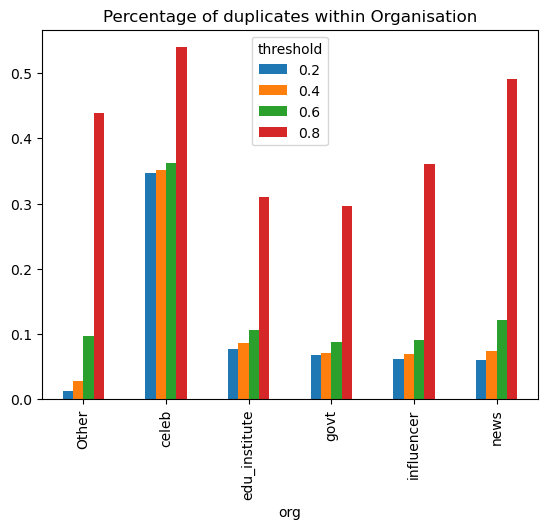

In [58]:
df_plt3.plot(stacked=False, kind = 'bar', title = 'Percentage of duplicates within Organisation')
plt.show()